# Predict Stock Fund Price Using Tensoflow LSTM (Long-Short-Term-Memory)

In [33]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [34]:
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
import math
import itertools
from datetime import date, datetime, timedelta
from timeit import default_timer as timer


#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score

#!pip install tensorflow --quiet
import tensorflow as tf
import keras

# !pip install keras --quiet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [35]:
import platform
print(f"Python version: {platform.python_version()}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Kersa version: {keras.__version__}")

Python version: 3.10.13
TensorFlow version: 2.15.0
Kersa version: 2.15.0


In [36]:
# Check GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device NOT found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device NOT found


In [37]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Failed to detect a GPU.


In [38]:
#!pip3 install torch torchvision torchaudio --quiet

In [39]:
import torch
import torch.nn as nn
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA installed: {torch.cuda.is_available()}")

PyTorch version: 2.2.1+cpu
CUDA installed: False


In [40]:
#!pip install yfinance  # Yahoo! Finance's API
import yfinance as yf

### Load Data:

In [309]:
# Date must be in the fromat ("%Y-%m-%d") That is, year-month-day
start_date = '2003-1-1' #1 Jan 2003
end_date = '2024-1-1'           #2  # date.today()     current date
# "start_date" must be an older date than the "end_date"

ticker = "PREIX"   # T. Rowe Price Equity Index 500 Fund

stock = yf.download(tickers = ticker,
                  start = start_date,
                  end = end_date)

[*********************100%%**********************]  1 of 1 completed


### Data Exploration

In [310]:
stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-02,24.450001,24.450001,24.450001,24.450001,16.627834,0
2003-01-03,24.440001,24.440001,24.440001,24.440001,16.621033,0
2003-01-06,24.990000,24.990000,24.990000,24.990000,16.995071,0
2003-01-07,24.830000,24.830000,24.830000,24.830000,16.886267,0
2003-01-08,24.490000,24.490000,24.490000,24.490000,16.655033,0


In [311]:
stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,124.989998,124.989998,124.989998,124.989998,124.989998,0
2023-12-26,125.510002,125.510002,125.510002,125.510002,125.510002,0
2023-12-27,125.699997,125.699997,125.699997,125.699997,125.699997,0
2023-12-28,125.760002,125.760002,125.760002,125.760002,125.760002,0
2023-12-29,125.410004,125.410004,125.410004,125.410004,125.410004,0


In [312]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5285 entries, 2003-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5285 non-null   float64
 1   High       5285 non-null   float64
 2   Low        5285 non-null   float64
 3   Close      5285 non-null   float64
 4   Adj Close  5285 non-null   float64
 5   Volume     5285 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 289.0 KB


In [313]:
stock.asfreq('B').index  # set index frequency to business daliy

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21',
               '2023-12-22', '2023-12-25', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5477, freq='B')

In [314]:
stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.0
mean,55.678874,55.678874,55.678874,55.678874,48.462129,0.0
std,28.554171,28.554171,28.554171,28.554171,30.399879,0.0
min,18.280001,18.280001,18.280001,18.280001,13.750332,0.0
25%,33.020000,33.020000,33.020000,33.020000,24.445610,0.0
50%,44.540001,44.540001,44.540001,44.540001,36.315392,0.0
75%,73.809998,73.809998,73.809998,73.809998,66.668495,0.0
max,126.099998,126.099998,126.099998,126.099998,125.760002,0.0


In [315]:
stock.isnull().sum(axis=0) # check any NA

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Data Visualization

Text(0.5, 1.0, 'The Stock Close Price of PREIX')

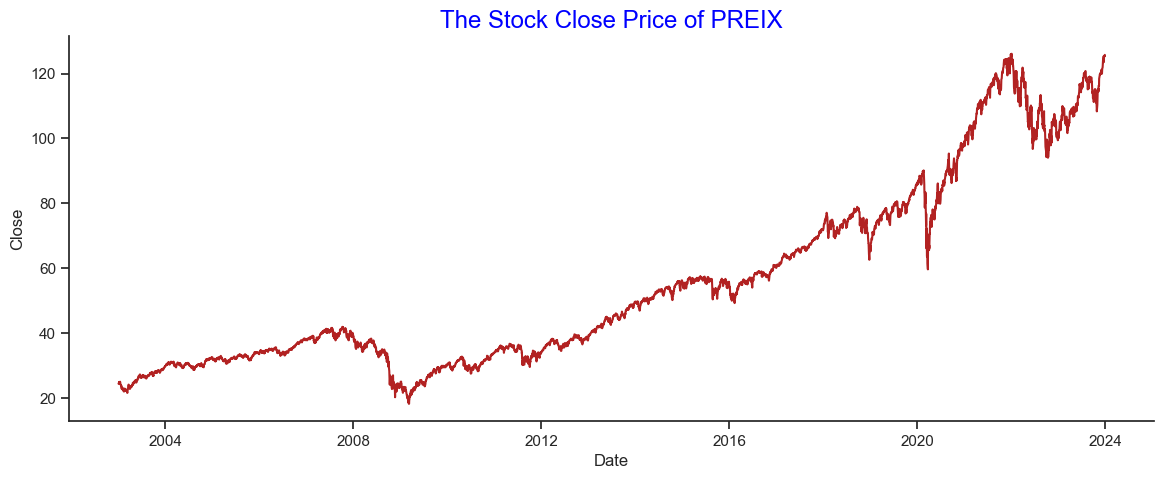

In [316]:
plt.figure(figsize=(14,5))
sns.set_theme(style="ticks")
sns.lineplot(data=stock,x="Date",y='Close',color='firebrick')
sns.despine()
plt.title("The Stock Close Price of " + ticker,size='x-large',color='blue')

### Splitting Data into a Training set and a Test set

In [317]:
df = stock[['Close']]
df.head()

,Close
Date,
2003-01-02,24.450001
2003-01-03,24.440001
2003-01-06,24.990000
2003-01-07,24.830000
2003-01-08,24.490000


In [318]:
# we took 80% of data for training and the rest 20% for testing

train_size = int(len(df['Close'])*0.8)
test_size = train_size  - 50   # 50 (timestamps) entries for prediction

In [319]:
df = df['Close'].values.reshape(-1,1)
train_data, test_data = np.array(df[:train_size]), np.array(df[test_size:])

In [320]:
train_data.shape

(4228, 1)

In [321]:
test_data.shape  # has 50 rows overlaped

(1107, 1)

### Normalizing the Data

In [322]:
# Scale the data 

# we use fit_transform() on training data but transform() on the test data
# https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
# https://www.analyticsvidhya.com/blog/2021/04/difference-between-fit-transform-fit_transform-methods-in-scikit-learn-with-python-code/

scaler = MinMaxScaler(feature_range=(0,1))
#train_set_scaled = scaler.fit_transform(np.array(train_data).reshape(-1,1))
#test_set_scaled = scaler.transform(np.array(test_data).reshape(-1,1))

train_set_scaled = scaler.fit_transform(train_data)
test_set_scaled = scaler.transform(test_data)

### Incorporating Timesteps Into Data

In [323]:
# Creating a dataset function with n timesteps

def create_dataset(dataset, time_step):
    dataX, dataY = [],[]   # dataX takes the values as its input , dataY takes the values as output.
    for i in range(time_step, len(dataset)):
                   dataX.append(dataset[i-time_step:i, 0])
                   dataY.append(dataset[i,0])
    return np.array(dataX), np.array(dataY)

#### use a time step of 50 days.
#### first 50 close prices (0 to 50), 1st 50 price will be in X_train data
#### Then predict the price of 51th day; and 51th price will be in y_train data

In [325]:
# calling the create dataset function to split the data into 
# input output datasets with time step 50
timestep = 50
# For each element in the training data, I take the previous 50 closing prices as the input (x_train), 
# and the next closing price as the output (y_train).
X_train, y_train =  create_dataset(train_set_scaled,timestep)
X_test, y_test =  create_dataset(test_set_scaled,timestep)

In [326]:
# checking values
print(X_train.shape)
print(y_train.shape)
#print(X_train)
print(X_test.shape)
print(y_test.shape)

(4178, 50)
(4178,)
(1057, 50)
(1057,)


In [327]:
# Reshape input data for LSTM, since LSTM takes 3 dimensional data as an input.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [328]:
# checking values
print(X_train.shape)
print(X_test.shape)

(4178, 50, 1)
(1057, 50, 1)


### Creating and fitting LSTM model
#### 5 layers of LSTM with 1 as input layer, 2 as hidden layers, 1 additonal dense layer and 1 for output layer as Dense.

In [330]:
# Define the model

# Activation function to use. Default: hyperbolic tangent (tanh).

# I choice units=512  : The number of units actually is the dimension of the hidden state (or the output).
# https://tung2389.github.io/coding-note/unitslstm

# A common practice is to use a dropout rate of 0.2 to 0.5 for the input and output layers,
# and a lower rate of 0.1 to 0.2 for the recurrent layers.
# https://www.linkedin.com/advice/3/how-do-you-scale-up-your-lstm-model

model = tf.keras.Sequential([
    LSTM(units = 512, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    Dropout(0.2),    #  aviod overfitting
    LSTM(units = 256, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 128),
    Dropout(0.2),    
    Dense(units=64, activation='relu'),  # Dense is used to make sure we have a fully connected neural network.
    Dense(units = 1)   # output layer
    ])


In [331]:
# Summary of the model 
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 50, 512)           1052672   
                                                                 
 dropout_24 (Dropout)        (None, 50, 512)           0         
                                                                 
 lstm_25 (LSTM)              (None, 50, 256)           787456    
                                                                 
 dropout_25 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_26 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)               

In [332]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [333]:
# Compile the model 
adamopt = tf.keras.optimizers.Adam()
mae = tf.keras.metrics.MeanAbsoluteError()
model.compile(optimizer=adamopt, loss = 'mean_squared_error', metrics=[mae] )  

# Regression Metrics  https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
# metrics=['mse', 'mae', 'mape', 'cosine']

####  https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

    The batch size is a number of samples processed before the model is updated.

    The number of epochs is the number of complete passes through the training dataset.

    The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset. 

    Worked Example:
    Finally, let’s make this concrete with a small example.

    Assume you have a dataset with 200 samples (rows of data) and you choose a batch size of 5 and 1,000 epochs.

    This means that the dataset will be divided into 40 batches, each with five samples. The model weights will be updated after each batch of five samples.

    This also means that one epoch will involve 40 batches or 40 updates to the model.

    With 1,000 epochs, the model will be exposed to or pass through the whole dataset 1,000 times. That is a total of 40,000 batches during the entire training process.

    verbose=0 will show you nothing (silent)

    verbose=1 will show you an animated progress bar like this: [==============================]

    verbose=2 will just mention the number of epoch like this:   Epoch 1/100 ....


In [334]:
start = timer() 
# Fitting the network to the Training set

# you need to choose the right size for your mini-batches, 
# as batches that are too small or too large can affect the convergence and accuracy of your model. 
# A common rule of thumb is to use a power of 2, such as 32, 64, or 128, as your batch size.
# https://www.linkedin.com/advice/3/how-do-you-scale-up-your-lstm-model

history = model.fit(X_train, y_train, epochs =100, batch_size = 32, verbose = 1)

end =  timer()
print("Time used: ",timedelta(seconds=end-start))

Epoch 1/100
131/131 [==============================] - 24s 150ms/step - loss: 0.0066 - mean_absolute_error: 0.0429
Epoch 2/100
131/131 [==============================] - 20s 154ms/step - loss: 0.0010 - mean_absolute_error: 0.0220
Epoch 3/100
131/131 [==============================] - 21s 161ms/step - loss: 8.7118e-04 - mean_absolute_error: 0.0208
Epoch 4/100
131/131 [==============================] - 21s 161ms/step - loss: 8.0705e-04 - mean_absolute_error: 0.0198
Epoch 5/100
131/131 [==============================] - 21s 158ms/step - loss: 8.1990e-04 - mean_absolute_error: 0.0199
Epoch 6/100
131/131 [==============================] - 21s 159ms/step - loss: 7.5255e-04 - mean_absolute_error: 0.0189
Epoch 7/100
131/131 [==============================] - 21s 157ms/step - loss: 5.4452e-04 - mean_absolute_error: 0.0161
Epoch 8/100
131/131 [==============================] - 21s 161ms/step - loss: 7.3616e-04 - mean_absolute_error: 0.0185
Epoch 9/100
131/131 [==============================] - 2

131/131 [==============================] - 19s 148ms/step - loss: 2.4354e-04 - mean_absolute_error: 0.0116
Epoch 70/100
131/131 [==============================] - 20s 151ms/step - loss: 2.7136e-04 - mean_absolute_error: 0.0123
Epoch 71/100
131/131 [==============================] - 19s 149ms/step - loss: 2.7242e-04 - mean_absolute_error: 0.0124
Epoch 72/100
131/131 [==============================] - 19s 148ms/step - loss: 2.7929e-04 - mean_absolute_error: 0.0126
Epoch 73/100
131/131 [==============================] - 20s 149ms/step - loss: 2.6230e-04 - mean_absolute_error: 0.0120
Epoch 74/100
131/131 [==============================] - 19s 148ms/step - loss: 2.7335e-04 - mean_absolute_error: 0.0124
Epoch 75/100
131/131 [==============================] - 20s 150ms/step - loss: 2.5738e-04 - mean_absolute_error: 0.0120
Epoch 76/100
131/131 [==============================] - 19s 148ms/step - loss: 2.6204e-04 - mean_absolute_error: 0.0121
Epoch 77/100
131/131 [==============================]

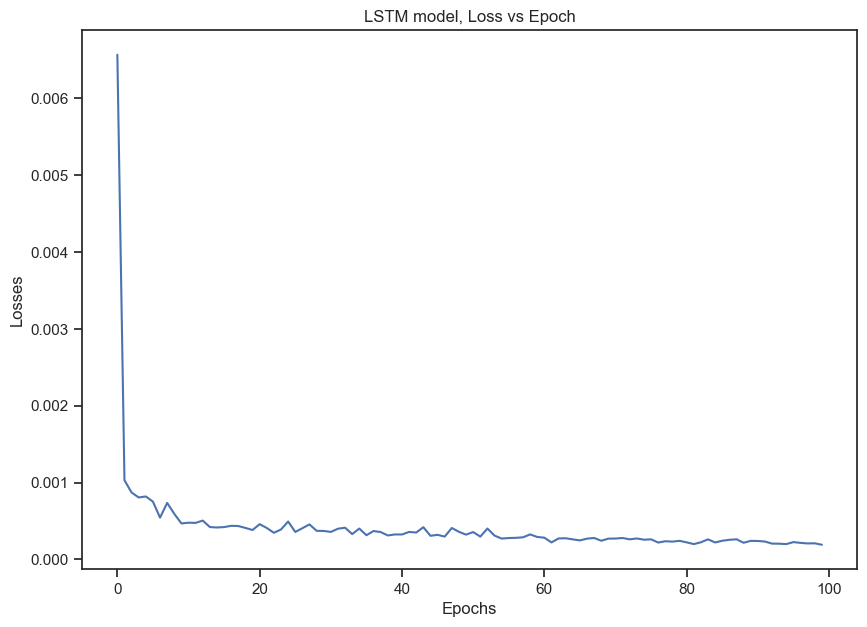

In [335]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

In [336]:
# Evaluate the model on the train set
print("Evaluate on train data")
results = model.evaluate(X_train, y_train, verbose=0, batch_size=42)
print("train loss , train MAE:", results)

Evaluate on train data
train loss , train MAE: [7.460308552253991e-05, 0.006147801410406828]


### Making Predictions on the Test Set

In [337]:
y_pred = model.predict(X_test)
predictions = scaler.inverse_transform(y_pred)
print(f"RMSE= {math.sqrt(mean_squared_error(y_test, predictions))}" )

34/34 [==============================] - 2s 47ms/step
RMSE= 103.70270044248204


In [338]:
mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 2.63%


In [339]:
y_pred.shape, X_test.shape

((1057, 1), (1057, 50, 1))

In [340]:
# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9625997400825554


### Graph Plotting

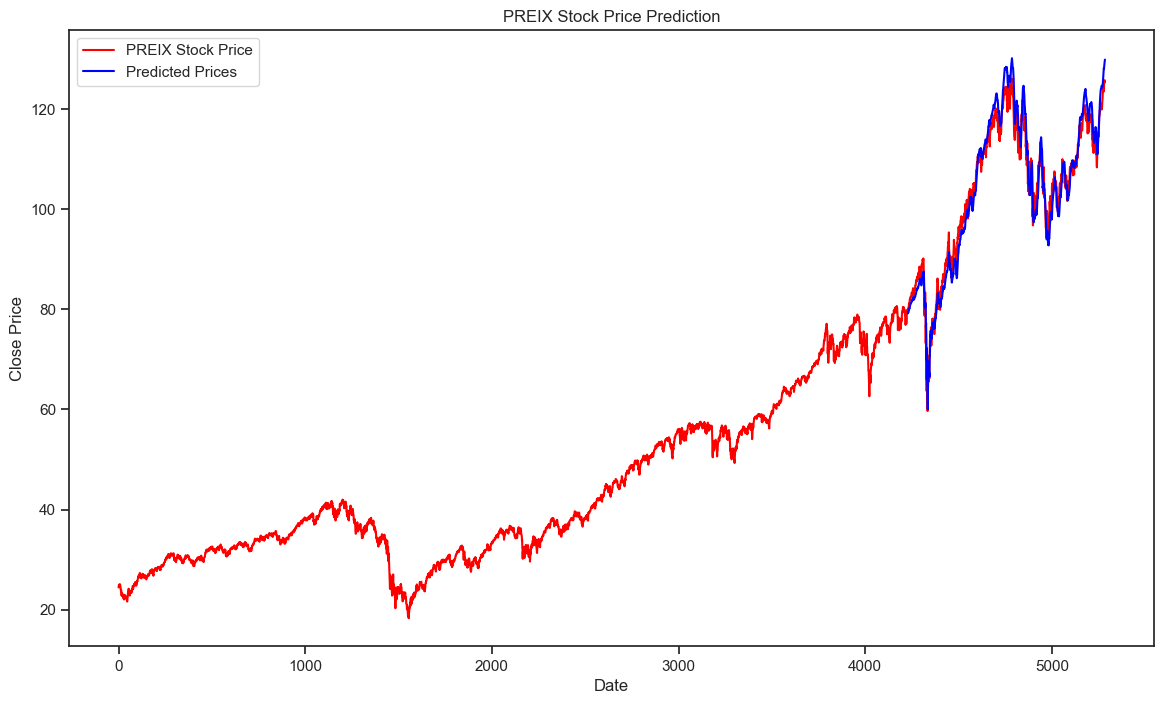

In [341]:
fig, ax = plt.subplots(figsize=(14,8))

plt.plot(df, color = 'red', label = ticker +' Stock Price')
ax.plot(range(len(y_train) + 50 , len(y_train) + 50 +len(predictions) ), predictions, color='blue', label="Predicted Prices")
plt.title(ticker +' Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

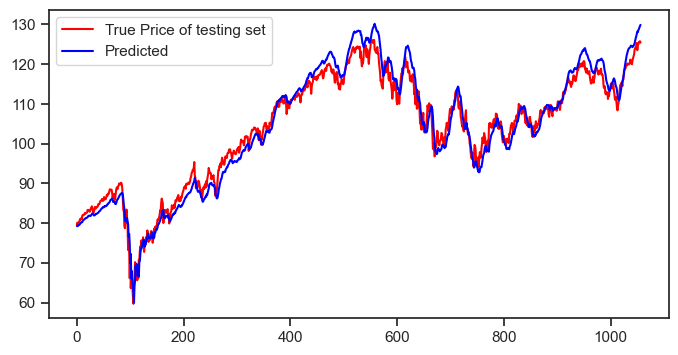

In [342]:
# plot only test data and compare with predicted
y_test_scaled =scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label = 'True Price of testing set')
plt.plot(predictions, color = 'blue', label='Predicted')
plt.legend()
plt.show()

In [343]:
#model.save('tf_keras_LSTM_model.h5')

 It can accurately follow most unusual jumps/drops; however, we can observe that the model expected (predicted) lower values than the actual stock price for the most recent date stamps.

### Future price prediction

In [344]:
# Which day is the last day in our data?
stock.iloc[-1]

Open         125.410004
High         125.410004
Low          125.410004
Close        125.410004
Adj Close    125.410004
Volume         0.000000
Name: 2023-12-29 00:00:00, dtype: float64

In [345]:
# We can predict the open price for the day after 12/29/2023--> for 01/02/2024.
# We will use last 50 days Open price as input of our model for this prediction

In [346]:
X_input = stock.iloc[-timestep:].Close.values                     # getting last 50 rows and converting to array
X_input_scaled = scaler.transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input_3d = np.reshape(X_input_scaled, (1,50,1))                           # reshaping : converting to 3D array
print("Shape of X_input :", X_input_3d.shape)

Shape of X_input : (1, 50, 1)


In [347]:
LSTM_prediction = scaler.inverse_transform(model.predict(X_input_3d))
print("LSTM prediction, Close price prediction for 01/02/2024 :", LSTM_prediction[0,0])

1/1 [==============================] - 0s 109ms/step
LSTM prediction, Close price prediction for 01/02/2024 : 129.9496


In [348]:
# re-code
#Get last 50 days values and convert into array
last_50_days=stock.iloc[-timestep:].Close.values 

#Scale the data to be values between 0
last_50_days_scaled=scaler.transform(last_50_days.reshape(-1,1))

#Create an empty list
X_test=[]
#Appemd the past 50days
X_test.append(last_50_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Price of {ticker} tomorrow:{pred_price}')

1/1 [==============================] - 0s 78ms/step
Price of PREIX tomorrow:[[129.9496]]


In [349]:
# Get the quote
stock_quote = yf.download(ticker,  start='2024-01-02', end='2024-01-03')
stock_quote

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,124.699997,124.699997,124.699997,124.699997,124.699997,0


#### Actual Close Price  is USD124.70 on Jan2, 2024

### Conclusion

#### It is impossible to get a perfect model that predict the price without any error, there are too many factors can affect the stock prices. 

### Reference
    
    https://www.datacamp.com/tutorial/lstm-python-stock-market
    
    https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
    https://medium.com/@prajjwalchauhan94017/stock-prediction-and-forecasting-using-lstm-long-short-term-memory-9ff56625de73
    https://github.com/mwitiderrick/stockprice/blob/master/TATA%20.ipynb
    https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce
    https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571
    https://www.datacamp.com/tutorial/ten-important-updates-tensorflow
    
    https://wandb.ai/ayush-thakur/dl-question-bank/reports/ReLU-vs-Sigmoid-Function-in-Deep-Neural-Networks--VmlldzoyMDk0MzI
    https://www.educative.io/answers/sigmoid-vs-relu
    https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/
    https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
    https://www.linkedin.com/advice/3/how-do-you-scale-up-your-lstm-model


    Predicting Stock Prices with LSTMs: One Mistake Everyone Makes (Episode 16)
        https://www.youtube.com/watch?v=Vfx1L2jh2Ng

    Stock Price Prediction with Machine Learning Mistakes: Prices As Inputs (Episode 20)
        https://www.youtube.com/watch?v=aIklUbW0UWI

    Common Mistakes in Stock Price Prediction: Prices As Targets (Episode 21)
        https://www.youtube.com/watch?v=xOcyV5Q2G5I

    Common Mistakes in Stock Price Prediction: Train-Test Split (Episode 22)
        https://www.youtube.com/watch?v=6t9hKclQNH4&t=8s

#### Research Paper:
    
    Predicting stock market index using LSTM 
        https://www.sciencedirect.com/science/article/pii/S2666827022000378
    Stock Price Prediction Using Machine Learning and LSTM-Based Deep Learning Models
        https://www.techrxiv.org/users/680450/articles/683786-stock-price-prediction-using-machine-learning-and-lstm-based-deep-learning-models
    Stock Price Prediction using LSTM Model    
        https://drpress.org/ojs/index.php/HSET/article/view/7352/7153